# A Simple Demo of AdaSTEM model using stemflow package

Yangkang Chen<br>
Sep 12, 2023

In [1]:

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import os
import h3pandas

# warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv(f'./stemflow/dataset/test_data/Sample_data_Mallard.csv')


# Get X and y

In [4]:
X = data.drop('count', axis=1)
y = data['count'].values


# First thing first: Spatio-temporal train test split

In [5]:
from stemflow.model_selection import ST_train_test_split
X_train, X_test, y_train, y_test = ST_train_test_split(X, y, 
                                                       Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                       random_state=42, test_size=0.3)


# Train AdaSTEM hurdle model

In [6]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


In [7]:
model = Hurdle_for_AdaSTEM(
    classifier=AdaSTEMClassifier(base_model=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=25,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=25,
                                grid_len_lat_lower_threshold=5,
                                points_lower_threshold=50,
                                Spatio1='longitude',
                                Spatio2 = 'latitude', 
                                Temporal1 = 'DOY',
                                use_temporal_to_train=True,
                                njobs=4),
    regressor=AdaSTEMRegressor(base_model=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                                save_gridding_plot = True,
                                ensemble_fold=10, 
                                min_ensemble_required=7,
                                grid_len_lon_upper_threshold=25,
                                grid_len_lon_lower_threshold=5,
                                grid_len_lat_upper_threshold=25,
                                grid_len_lat_lower_threshold=5,
                                points_lower_threshold=50,
                                Spatio1='longitude',
                                Spatio2 = 'latitude', 
                                Temporal1 = 'DOY',
                                use_temporal_to_train=True,
                                njobs=4)
)





In [8]:
model.fit(X_train.reset_index(drop=True), y_train)

100%|██████████| 13712/13712 [01:52<00:00, 121.72it/s] 


# Feature importances

In [9]:
# Calcualte feature importance. This method is automatically called when fitting the model.
# However, to show the process, we call it again.
model.classifier.calculate_feature_importances()
# stixel-specific feature importance is saved in model.classifier.feature_importances_

In [10]:
# Assign the feature importance to spatio-temporal points of interest
importances_by_points = model.classifier.assign_feature_importances_by_points(verbosity=1, njobs=4)


100%|██████████| 10/10 [07:11<00:00, 43.16s/it]


In [11]:
importances_by_points.head()

DOY  longitude  latitude  DOY_predictor  duration_minutes  Traveling  \
762371  134        164       -51       0.025259          0.060387   0.000000   
762424  134        165       -51       0.025259          0.060387   0.000000   
762717  330        170       -51       0.019641          0.023954   0.008790   
762718  337        170       -51       0.019641          0.023954   0.008790   
762719  344        170       -51       0.021659          0.024769   0.008972   

        Stationary  Area  effort_distance_km  number_observers  \
762371         0.0   0.0            0.055147          0.003262   
762424         0.0   0.0            0.055147          0.003262   
762717         0.0   0.0            0.033002          0.011528   
762718         0.0   0.0            0.033002          0.011528   
762719         0.0   0.0            0.029707          0.010139   

        obsvr_species_count  time_observation_started_minute_of_day  \
762371             0.069978                                0.086718   
762424             0.069978                                0.086718   
762717             0.018917                                0.029223   
762718             0.018917                                0.029223   
762719             0.019287                                0.029368   

        elevation_mean  slope_mean  eastness_mean  northness_mean      bio1  \
762371        0.076886    0.011744       0.072400        0.023945  0.012036   
762424        0.076886    0.011744       0.072400        0.023945  0.012036   
762717        0.026940    0.059196       0.029316        0.015506  0.011279   
762718        0.026940    0.059196       0.029316        0.015506  0.011279   
762719        0.024565    0.056263       0.028196        0.013751  0.008391   

            bio2      bio3      bio4      bio5      bio6      bio7      bio8  \
762371  0.007702  0.021151  0.041256  0.010396  0.016005  0.030584  0.040039   
762424  0.007702  0.021151  0.041256  0.010396  0.016005  0.030584  0.040039   
762717  0.046925  0.047804  0.005748  0.083550  0.072804  0.013608  0.011283   
762718  0.046925  0.047804  0.005748  0.083550  0.072804  0.013608  0.011283   
762719  0.053135  0.039531  0.005951  0.069442  0.066405  0.011774  0.012472   

            bio9     bio10     bio11     bio12     bio13     bio14     bio15  \
762371  0.032515  0.004392  0.000000  0.000726  0.007942  0.010532  0.001339   
762424  0.032515  0.004392  0.000000  0.000726  0.007942  0.010532  0.001339   
762717  0.025309  0.020491  0.016157  0.022350  0.019653  0.015334  0.004302   
762718  0.025309  0.020491  0.016157  0.022350  0.019653  0.015334  0.004302   
762719  0.021980  0.011568  0.017558  0.036248  0.036392  0.016034  0.004906   

           bio16     bio17     bio18     bio19  croplands  \
762371  0.001918  0.000343  0.021200  0.000000    0.00608   
762424  0.001918  0.000343  0.021200  0.000000    0.00608   
762717  0.009060  0.011720  0.047501  0.005597    0.00000   
762718  0.009060  0.011720  0.047501  0.005597    0.00000   
762719  0.006246  0.026611  0.046866  0.027986    0.00000   

        deciduous_broadleaf_forests  evergreen_broadleaf_forests  \
762371                          0.0                     0.000000   
762424                          0.0                     0.000000   
762717                          0.0                     0.026745   
762718                          0.0                     0.026745   
762719                          0.0                     0.022316   

        evergreen_needleleaf_forests  grasslands  mixed_forests  \
762371                      0.001686    0.073701       0.074472   
762424                      0.001686    0.073701       0.074472   
762717                      0.011608    0.067397       0.018835   
762718                      0.011608    0.067397       0.018835   
762719                      0.012405    0.060443       0.017845   

        non_vegetated_lands  permanent_wetlands  savannas  \
762371                  0.

In [12]:
# top 10 important variables
top_10_important_vars = importances_by_points[[
    i for i in importances_by_points.columns if not i in ['DOY','longitude','latitude','longitude_new','latitude_new']
    ]].mean().sort_values(ascending=False).head(10)

print(top_10_important_vars)


slope_mean             0.040453
effort_distance_km     0.037380
duration_minutes       0.036992
elevation_mean         0.036110
eastness_mean          0.033965
bio2                   0.032606
bio4                   0.032069
bio3                   0.030508
northness_mean         0.030287
obsvr_species_count    0.030101
dtype: float64


## Ploting the feature importances by vairable names

In [13]:
from stemflow.utils.plot_gif import make_sample_gif

# make spatio-temporal GIF for top 3 variables
for var_ in top_10_important_vars.index[:3]:
    make_sample_gif(importances_by_points, f'./test_output/FTR_IPT_{var_}.gif',
                                col=var_, log_scale = False,
                                Spatio1='longitude', Spatio2='latitude', Temporal1='DOY',
                                figsize=(18,9), xlims=(-180, 180), ylims=(-90,90), grid=True,
                                xtick_interval=20, ytick_interval=20,
                                lng_size = 360, lat_size = 180, dpi=100, fps=10)


0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!
0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!
0.0.0.0.0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.
Finish!


![GIF of feature importance for vairable `slope_mean`](../FTR_IPT_slope_mean.gif)

## Plot uncertainty (error) in training 

In [14]:
# calculate mean and standard deviation in occurence estiamtion (classifier)
pred_mean, pred_std = model.classifier.predict(X_train.reset_index(drop=True), 
                                               return_std=True, verbosity=1, njobs=1)



predicting ensemble 9 : 100%|██████████| 3829/3829 [00:07<00:00, 507.58it/s]


In [15]:
# Aggregate error to hexagon
error_df = X_train[['longitude', 'latitude']]
error_df.columns = ['lng', 'lat']
error_df['pred_std'] = pred_std

H_level = 3
error_df = error_df.h3.geo_to_h3(H_level)
error_df = error_df.reset_index(drop=False).groupby(f'h3_0{H_level}').mean()
error_df = error_df.h3.h3_to_geo_boundary()



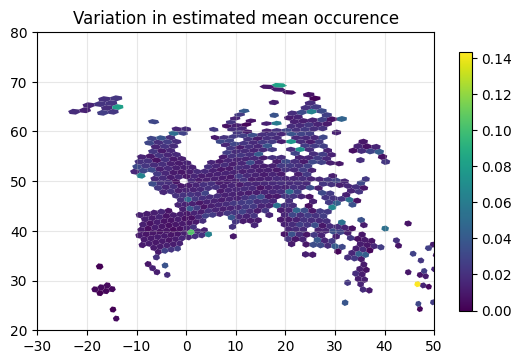

In [16]:
# plot mean error in hexagon
error_df.plot('pred_std', legend=True, legend_kwds={'shrink':0.7})
plt.grid(alpha=0.3)

plt.xlim(-30, 50)
plt.ylim(20, 80)
plt.title('Variation in estimated mean occurence')
plt.show()

# Save model

In [17]:
with open('./test_output/01.demo_adastem_model.pkl','wb') as f:
    pickle.dump(model, f)
    

# Evaluation

In [17]:
pred = model.predict(X_test)


In [18]:
perc = np.sum(np.isnan(pred.flatten()))/len(pred.flatten())
print(f'Percentage not predictable {round(perc*100, 2)}%')

Percentage not predictable 4.12%


In [19]:
pred_df = pd.DataFrame({
    'y_true':y_test.flatten(),
    'y_pred':np.where(pred.flatten()<0, 0, pred.flatten())
}).dropna()


In [20]:
AdaSTEM.eval_STEM_res('hurdle', pred_df.y_true, pred_df.y_pred)


{'AUC': 0.683914163165248,
 'kappa': 0.41829317784543896,
 'f1': 0.4979695431472082,
 'precision': 0.6054621200432032,
 'recall': 0.42289039767216297,
 'average_precision': 0.35215395653743475,
 'Spearman_r': 0.4379689320400645,
 'Pearson_r': 0.1311511307461011,
 'R2': -0.1742680217324486,
 'MAE': 4.038897057438504,
 'MSE': 1335.1555350523088,
 'poisson_deviance_explained': 0.13291683037653124}

# Compared to simple Hurdle model

In [21]:
model2 = Hurdle(classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
                regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1))
model2.fit(X_train[[i for i in X_train.columns if not i in ['longitude','latitude']]], y_train)
pred2 = model2.predict(X_test[[i for i in X_train.columns if not i in ['longitude','latitude']]])

AdaSTEM.eval_STEM_res('hurdle', y_test.flatten(), np.where(pred2.flatten()<0, 0, pred2.flatten()))

{'AUC': 0.614874754867373,
 'kappa': 0.3024531192247014,
 'f1': 0.3682267387656163,
 'precision': 0.643005991143527,
 'recall': 0.25798191984114544,
 'average_precision': 0.288061783500689,
 'Spearman_r': 0.3520394407206567,
 'Pearson_r': 0.15540117044791554,
 'R2': -0.11859108757092018,
 'MAE': 3.99918310458487,
 'MSE': 1405.505184365956,
 'poisson_deviance_explained': 0.06904965429918242}

# Plot QuadTree ensembles

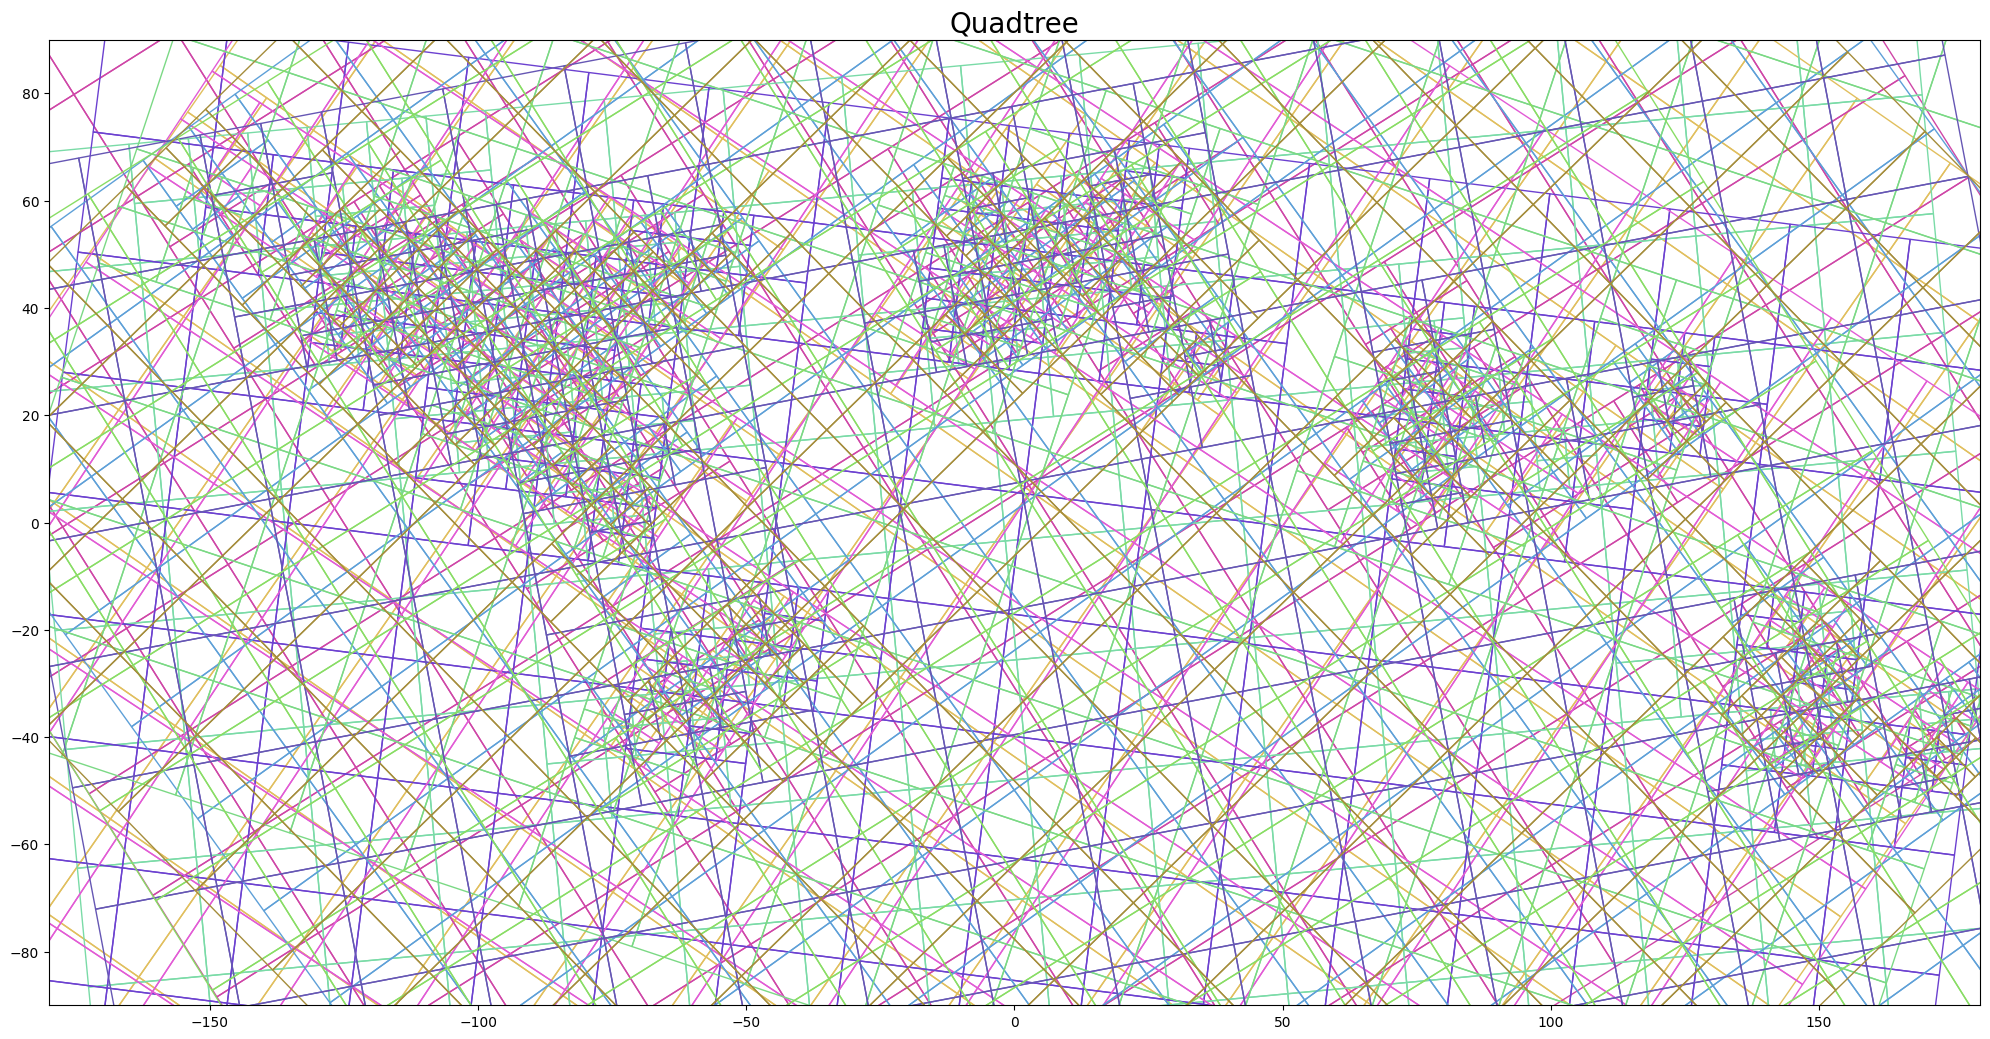

In [22]:
model.classifier.gridding_plot

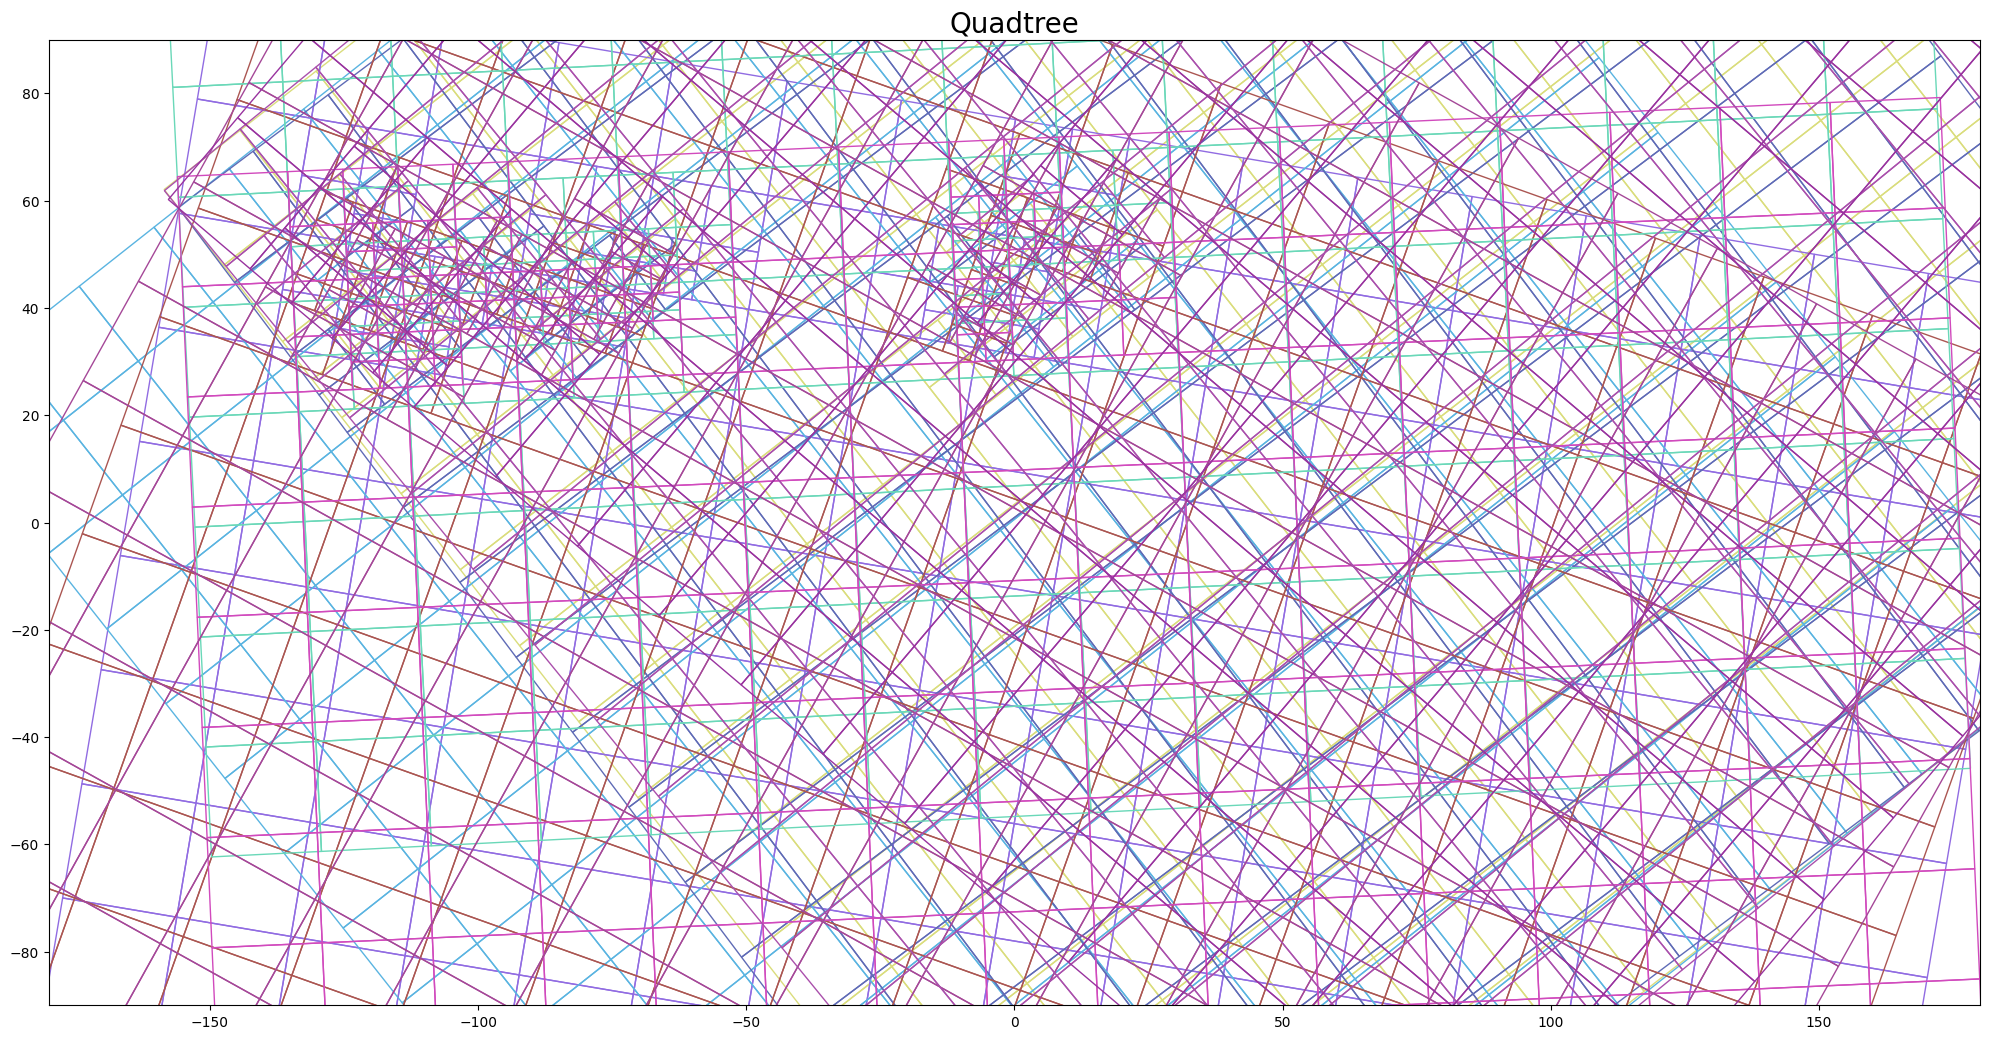

In [23]:
model.regressor.gridding_plot

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 12 2023

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.14.0

h3pandas  : 0.2.4
pandas    : 2.0.3
numpy     : 1.24.3
matplotlib: 3.7.1

Watermark: 2.3.1

